# SI Simulation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import nafot
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

## Loading the data

In [2]:
# Loading the contact matrices
contact_matrix = pd.read_csv('../data/matrix/contact_matrix_final_sample.csv')
contact_matrix_yeshuv = pd.read_csv('../data/matrix/contact_matrix_final_sample_yeshuv.csv')
contact_matrix_subdist = pd.read_csv('../data/matrix/contact_matrix_final_sample_subdist.csv')

# Setting index, dtype and replacing nan with 0
# Stat area contact matrix
contact_matrix.set_index(contact_matrix.columns[0], inplace=True)
contact_matrix.columns = contact_matrix.columns.astype(int)
contact_matrix.fillna(0, inplace=True)
# Yeshuv contact matrix
contact_matrix_yeshuv.set_index(contact_matrix_yeshuv.columns[0], inplace=True)
contact_matrix_yeshuv.columns = contact_matrix_yeshuv.columns.astype(int)
contact_matrix_yeshuv.fillna(0, inplace=True)
# Subdist contact matrix
contact_matrix_subdist.set_index(contact_matrix_subdist.columns[0], inplace=True)
contact_matrix_subdist.columns = contact_matrix_subdist.columns.astype(float)
contact_matrix_subdist.fillna(0, inplace=True)

NameError: name 'pd' is not defined

In [4]:
# Get a list of the relevant areas
areas = contact_matrix.index

# Get the population dictionary
pop_dict = nafot.get_population_dict('stat_area')
population = np.array([pop_dict[area] for area in areas])

# Calculate population proportion
total_pop = population.sum()
pop_prop_dict = {area: pop_dict[area]/total_pop for area in areas}
pop_prop = np.array([prop for prop in pop_prop_dict.values()])

In [5]:
# Get a list of the relevant areas
areas = contact_matrix_subdist.index.astype('int32')

# Get the population dictionary
pop_dict = nafot.get_population_dict('subdistrict')
population = np.array([pop_dict[area] for area in areas])

# Calculate population proportion
total_pop = population.sum()
pop_prop_dict = {area: pop_dict[area]/total_pop for area in areas}
pop_prop = np.array([prop for prop in pop_prop_dict.values()])

## SI Model
**Initialization:**
* $S_k(t=0)= popprop(k)$
* $I_k(t=0) \sim U \quad ∀k \quad s.t: \sum_k{I_k(t=0)}∈[10^{-4},10^{-3}]$

**Recursive equations:** 
* $S_k(t)=S_k(t-1)-\sum_j[c_{jk} \cdot \beta \cdot I_j(t-1)]\cdot S_k(t-1)+\gamma \cdot I_k(t-1)$
* $I_k(t)=I_k (t-1)+\sum_j[c_{jk}\cdot \beta \cdot I_j (t-1)]\cdot S_k (t-1)-\gamma \cdot I_k(t-1)$

**At each step:**
* $\sum_k S_k  (t)+I_k (t)=1 \quad ∀t$
* $S_k (t)+I_k (t)=popprop(k)$

### Parameters

In [137]:
np.random.seed(1)

# Parameters
gamma = 1/5
beta =  1.1*gamma

In [148]:
(1/(beta/gamma))/(beta/gamma)

0.8264462809917354

### Initialization

In [139]:
np.random.seed(1)

# Sampling the number of infected individuals
I0_total = int(np.random.uniform(10**-4, 10**-3)*total_pop)
# I0_total = int(np.random.uniform(10**-2,10**-1)*total_pop)

# Number of infected individuals in each area (uniformly by area population)
infected_0 = np.random.choice(areas, size=I0_total, replace=True, p=pop_prop) 
areas_infected_count = (np.bincount(infected_0))
infected_areas = np.nonzero(areas_infected_count)[0]
I0_absolute = np.array([areas_infected_count[area] if area in infected_areas else 0 for area in areas])

# Converting to porportions
I0 = I0_absolute/total_pop
# S0 = population - I0_absolute
S0 = pop_prop - I0

In [140]:
contact_matrix_subdist1 = contact_matrix_subdist.copy()*0 +1

In [149]:
S = S0.reshape((1,S0.size)).copy()
I = I0.reshape((1,I0.size)).copy()
new_infected_all = I0.reshape((1,I0.size)).copy() 

t=0
while t<1000:
    # Calculate S_t, I_t
    new_infected = (np.sum((contact_matrix_subdist.values*beta*I[-1]), axis=0)*S[-1])
    S_t  = S[-1] - new_infected + gamma*I[-1]
    I_t = I[-1] + new_infected - gamma*I[-1]
    
    s = S_t + I_t
#     if (s==0).any():
#         print (s, t)
#     print (s)
#     S_t = S_t/s
#     I_t = I_t/s
    # Save S_t, I_t, and new_infected
    S = np.vstack([S, S_t])
    I = np.vstack([I, I_t])
    new_infected_all = np.vstack([new_infected_all,new_infected])
    
    t+=1

In [142]:
(S + I).sum()

1000.9999999999998

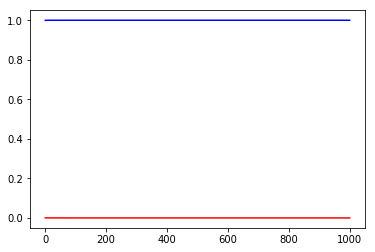

In [150]:
plt.plot(np.arange(t+1), S.sum(1), 'b');
plt.plot(np.arange(t+1), I.sum(1), 'r');

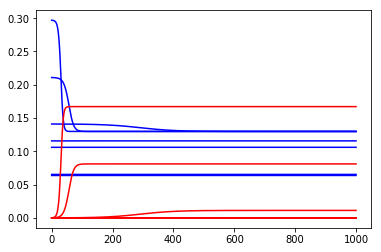

In [144]:
plt.plot(np.arange(t+1), S, 'b');
plt.plot(np.arange(t+1), I, 'r');